<a href="https://colab.research.google.com/github/25051980/Deep-learning_vers-o-final-Samuel/blob/main/MVP_II_Deep_Learning_vers%C3%A3o_final_Samuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Sentimentos em Tweets de Companhias Aéreas: Um Estudo de Caso

## Introdução
A análise de sentimentos é uma técnica poderosa que permite às empresas entenderem melhor as opiniões e emoções de seus clientes em relação aos seus produtos e serviços. Companhias aéreas nos Estados Unidos tem uma competição muito forte para manter clientes e mantê-los satisfeitos. Aqui foi abordado um problema que consiste em poder identificar/estudar a satisfação dos clientes a partir de comentários sobre as companhias aereas.

Neste trabalho, desenvolvemos um modelo de rede neural para analisar os sentimentos expressos em comentários sobre algumas companhias aéreas específicas e classificá-los em "Positivos - Neutrais" ou "Negativos". Nosso objetivo é fornecer insights valiosos para a empresa, a fim de ajudá-la a melhorar sua reputação e atendimento ao cliente.

Temos a hipótese de que o grau de satisfação está relacionado com a quantidade de comentários negativos. Este tipo de comentários, muitas vezes estão vinculados ao mau atendimento, mau servico, atrasos, entre outros, o que impacta negativamente a satisfação dos clientes.

Para desenvolver o trabalho tivemos como condição focar somente em comentários do tweeter.

### Bibliotecas necessárias

In [ ]:
# importando bibliotecas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas.core.api import DataFrame
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
# 1) Importando dados de uma url para um dataframe

# imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style
from matplotlib.pyplot import subplots
matplotlib.style.use('ggplot')
import seaborn as sns
from datetime import datetime
from scipy import stats # estatística
from sklearn.preprocessing import StandardScaler, OneHotEncoder # modelagem estatística. Padronização
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import os
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import LabelEncoder



### Carregando os dados dos tweets

In [ ]:
# url a importar
url_dados = 'https://raw.githubusercontent.com/25051980/MVP1/main/Tweets.csv'


# carga do dataset através do csv
df0 = pd.read_csv(url_dados)#

# exibe as 5 primeiras linhas
df0.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df0.columns #Observando as colunas do dataframe

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
df0.dtypes #Visualizando o tipo de cada coluna

tweet_id                        int64  
airline_sentiment               object 
airline_sentiment_confidence    float64
negativereason                  object 
negativereason_confidence       float64
airline                         object 
airline_sentiment_gold          object 
name                            object 
negativereason_gold             object 
retweet_count                   int64  
text                            object 
tweet_coord                     object 
tweet_created                   object 
tweet_location                  object 
user_timezone                   object 
dtype: object

In [ ]:
df0.shape #Dataframe com 14640 linhas e 15 colunas

(14640, 15)

In [ ]:
df=df0.head(600) #Os modelos foram rodados com apenas 5000 linhas devido ao custo computacional ser muito elevado
#df=df0.copy()

### Analizando e explorando os dados

In [ ]:
sentiment_counts = df.airline_sentiment.value_counts()
number_of_tweets = df.tweet_id.count()
print(sentiment_counts)

negative    241
neutral     194
positive    165
Name: airline_sentiment, dtype: int64


Temos um total de 6000 tweets, deles 61%(3655) são comentários negativos.

In [ ]:
dff = df.groupby(["airline", "airline_sentiment"]).count()["name"].reset_index(name="count")
total_comments = dff.groupby("airline")["count"].sum().reset_index(name="total_comments")
dff = dff.merge(total_comments, on="airline")
dff["percentage"] = dff["count"] / dff["total_comments"] * 100
dff

,airline,airline_sentiment,count,total_comments,percentage
0,United,negative,60,96,62.500000
1,United,neutral,23,96,23.958333
2,United,positive,13,96,13.541667
3,Virgin America,negative,181,504,35.912698
4,Virgin America,neutral,171,504,33.928571
5,Virgin America,positive,152,504,30.158730


A Aerolinha United lidera o ranking das que tem maior número de comentários negativos. Virgin America tem o maior % de comentários positivos

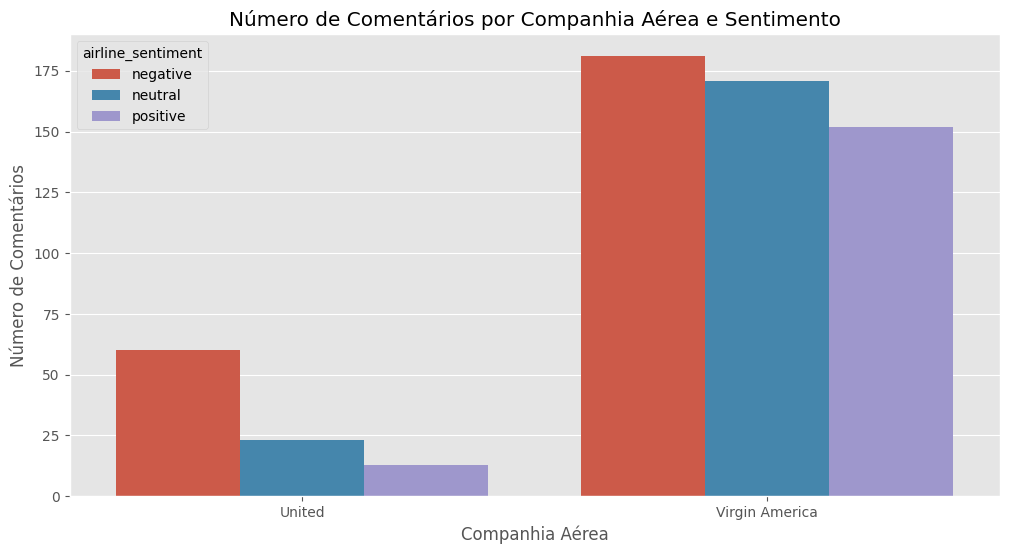

In [ ]:
# Agrupando os dados por companhia aérea e sentimento e contando o número de comentários
dff = df.groupby(["airline", "airline_sentiment"]).count()["name"].reset_index(name="count")

# Criando o gráfico de barras usando a biblioteca seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="airline", y="count", hue="airline_sentiment", data=dff)

plt.xlabel("Companhia Aérea")
plt.ylabel("Número de Comentários")
plt.title("Número de Comentários por Companhia Aérea e Sentimento")

plt.show()

Acontece que nosso conjunto de dados é desequilibrado, com significativamente mais tweets negativos do que positivos. Vamos nos concentrar na questão de identificar tweets negativos e, portanto, tratar neutros e positivos como uma classe. É bom ter em mente que, embora seja um classificador terrível, se sempre adivinhássemos que um tweet era negativo, estaríamos certos 62,7% das vezes (9178 de 14640). Isso claramente não seria um classificador muito útil, mas vale a pena lembrar.

In [ ]:
# Estas bibliotecas tem que ser abaixadas sempre que for rodar o código numa nova sessão.
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

Testando o funcionamento do Normalizer.

In [ ]:
normalizer("I went to the gym three times this week.")

['gym', 'three', 'time', 'week']

In [ ]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df['normalized_tweet'] = df.text.apply(normalizer)
df[['text','normalized_tweet']].head(5)

,text,normalized_tweet
0,@VirginAmerica What @dhepburn said.,"[dhepburn, said]"
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[added, commercial, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


In [ ]:
# Função para criar combinações de duas palavras contínuas e/ou três palavras continuas que se encontram em uma mesma frase.
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams # Bigramas e trigramas
df['grams'] = df.normalized_tweet.apply(ngrams)
df[['grams']].head()

,grams
0,[dhepburn said]
1,"[added commercial, commercial experience, experience tacky, added commercial experience, commercial experience tacky]"
2,"[today must, must mean, mean need, need take, take another, another trip, today must mean, must mean need, mean need take, need take another, take another trip]"
3,"[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face amp, amp little, little recourse, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guest, entertainment guest face, guest face amp, face amp little, amp little recourse]"
4,"[really big, big bad, bad thing, really big bad, big bad thing]"


In [ ]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [ ]:
df[(df.airline_sentiment == 'negative')][['grams']].apply(count_words)['grams'].most_common(10)

[('http co', 13),
 ('cancelled flightled', 9),
 ('late flight', 7),
 ('customer service', 6),
 ('flight flight', 6),
 ('flight booking', 5),
 ('booking problem', 5),
 ('flight booking problem', 5),
 ('cancelled flight', 5),
 ('flightled flight', 5)]

Geralmente os comentários negativos estão associados a reclamações por voos atrasados e/ou cancelados

In [ ]:
df[(df.airline_sentiment == 'positive')][['grams']].apply(count_words)['grams'].most_common(10)

[('http co', 26),
 ('customer service', 6),
 ('virgin america', 3),
 ('love guy', 3),
 ('every time', 2),
 ('time fly', 2),
 ('every time fly', 2),
 ('great deal', 2),
 ('first cross', 2),
 ('cross country', 2)]

Geralmente os comentários positivos estão associados a serviço ao cliente, atendimento da tripulação.

### Preparando os dados para aplicar o modelo de rede neural simples

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1,2))
vectorized_data = count_vectorizer.fit_transform(df.text)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [ ]:
# Convertendo o sentimento target a um inteiro. Negativo: 1 e Positivo/Neutro: 0
def sentiment2target(sentiment):
    return {
        'negative': 1,
        'neutral': 0,
        'positive' : 0
    }[sentiment]
targets = df.airline_sentiment.apply(sentiment2target)

In [ ]:
# Dividindo os dados nos grupos de treinamento e teste para aplicação da modelagem.
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.3, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

* Ajustando os dados com a aplicação de uma rede neural simples
* O teste e otimização de hiperparametros foi feito de forma manual, tentámos fazer um ciclo automatico com validação cruzada, mas não foi possivel devido ao custo computacional.
* Foi feita a comparação de resultados obtidos com o treinamento para cada conjunto de hiperparametros.






In [ ]:
# Definindo o tamanho do vocabulário e o comprimento máximo das sequências
vocab_size = 500 #Modelo final: colocar 5000, 8000
max_length = 8754

# Criando um modelo de rede neural simples
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5)), #Modelo final: LSTM=10
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando o modelo com uma função de perda e um otimizador
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convertendo os dados de treinamento em um tensor denso
data_train_dense = data_train.todense()
data_test_dense = data_test.todense()

# Treinando o modelo nos dados de treinamento
model.fit(data_train_dense, targets_train, epochs=10)

# Avaliando o modelo nos dados de teste
loss, accuracy = model.evaluate(data_test_dense, targets_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
14/14 [==============================] - 293s 20s/step - loss: 0.6848 - accuracy: 0.6095
Epoch 2/10
14/14 [==============================] - 283s 20s/step - loss: 0.6732 - accuracy: 0.6095
Epoch 3/10
14/14 [==============================] - 281s 20s/step - loss: 0.6706 - accuracy: 0.6095
Epoch 4/10
14/14 [==============================] - 283s 20s/step - loss: 0.6698 - accuracy: 0.6095
Epoch 5/10
14/14 [==============================] - 282s 20s/step - loss: 0.6695 - accuracy: 0.6095
Epoch 6/10
14/14 [==============================] - 280s 20s/step - loss: 0.6697 - accuracy: 0.6095
Epoch 7/10
14/14 [==============================] - 272s 19s/step - loss: 0.6702 - accuracy: 0.6095
Epoch 8/10
14/14 [==============================] - 275s 20s/step - loss: 0.6689 - accuracy: 0.6095
Epoch 9/10
14/14 [==============================] - 273s 20s/step - loss: 0.6691 - accuracy: 0.6095
Epoch 10/10
6/6 [==============================] - 7s 1s/step - loss: 0.6851 - accuracy: 0.5722
Test

#### Teste n: 1
Rodada 27/06
Epoch 1/10
12/12 [==============================] - 227s 18s/step - loss: 0.6906 - accuracy: 0.5722
Epoch 2/10
12/12 [==============================] - 221s 18s/step - loss: 0.6825 - accuracy: 0.6000
Epoch 3/10
12/12 [==============================] - 219s 18s/step - loss: 0.6780 - accuracy: 0.6000
Epoch 4/10
12/12 [==============================] - 218s 18s/step - loss: 0.6737 - accuracy: 0.6000
Epoch 5/10
12/12 [==============================] - 219s 18s/step - loss: 0.6734 - accuracy: 0.6000
Epoch 6/10
12/12 [==============================] - 217s 18s/step - loss: 0.6731 - accuracy: 0.6000
Epoch 7/10
12/12 [==============================] - 218s 18s/step - loss: 0.6736 - accuracy: 0.6000
Epoch 8/10
12/12 [==============================] - 221s 18s/step - loss: 0.6736 - accuracy: 0.6000
Epoch 9/10
12/12 [==============================] - 218s 18s/step - loss: 0.6742 - accuracy: 0.6000
Epoch 10/10
12/12 [==============================] - 219s 18s/step - loss: 0.6731 - accuracy: 0.6000
8/8 [==============================] - 8s 957ms/step - loss: 0.6748 - accuracy: 0.5958
Test Accuracy: 0.5958333611488342

#### Teste n: 2

Rodada Antiga 20/06 Epoch 1/10
3/3 [==============================] - 18s 4s/step - loss: 0.6919 - accuracy: 0.3625

Epoch 2/10
3/3 [==============================] - 13s 4s/step - loss: 0.6683 - accuracy: 0.3875

Epoch 3/10
3/3 [==============================] - 13s 4s/step - loss: 0.6463 - accuracy: 0.3875

Epoch 4/10
3/3 [==============================] - 14s 5s/step - loss: 0.6223 - accuracy: 0.3875

Epoch 5/10
3/3 [==============================] - 13s 4s/step - loss: 0.6005 - accuracy: 0.3875

Epoch 6/10
3/3 [==============================] - 13s 4s/step - loss: 0.5770 - accuracy: 0.3875

Epoch 7/10
3/3 [==============================] - 13s 4s/step - loss: 0.5481 - accuracy: 0.3875

Epoch 8/10
3/3 [==============================] - 13s 4s/step - loss: 0.5169 - accuracy: 0.3875

Epoch 9/10
3/3 [==============================] - 13s 4s/step - loss: 0.4857 - accuracy: 0.3875

Epoch 10/10
3/3 [==============================] - 13s 4s/step - loss: 0.4470 - accuracy: 0.3875

4/4 [==============================] - 54s 363ms/step - loss: 0.5437 - accuracy: 0.2833
Test Accuracy: 0.28333333134651184

#### Teste n: 3

Epoch 1/10
44/44 [==============================] - 11441s 260s/step - loss: 0.6695 - accuracy: 0.6264

Epoch 2/10
40/44 [==========================>...] - ETA: 17:05 - loss: 0.6634 - accuracy: 0.6227

Este teste foi interrompido/travou depois de mais de 6h. Os resultados pareciam ser bons mas o poder computacional do meu computador, não foi suficiente para lidar com este modelo.

#### Teste n: 4

Epoch 1/10
44/44 [==============================] - 10858s 246s/step - loss: 0.6698 - accuracy: 0.6264

Epoch 2/10
15/44 [=========>....................] - ETA: 1:56:05 - loss: 0.6504 - accuracy: 0.6458

Este teste foi interrompido/travou depois de mais de 4h. Os resultados pareciam ser bons mas o poder computacional do meu computador, não foi suficiente para lidar com este modelo.  

#### Teste n: 5

Epoch 1/10
14/14 [==============================] - 293s 20s/step - loss: 0.6848 - accuracy: 0.6095
Epoch 2/10
14/14 [==============================] - 283s 20s/step - loss: 0.6732 - accuracy: 0.6095
Epoch 3/10
14/14 [==============================] - 281s 20s/step - loss: 0.6706 - accuracy: 0.6095
Epoch 4/10
14/14 [==============================] - 283s 20s/step - loss: 0.6698 - accuracy: 0.6095
Epoch 5/10
14/14 [==============================] - 282s 20s/step - loss: 0.6695 - accuracy: 0.6095
Epoch 6/10
14/14 [==============================] - 280s 20s/step - loss: 0.6697 - accuracy: 0.6095
Epoch 7/10
14/14 [==============================] - 272s 19s/step - loss: 0.6702 - accuracy: 0.6095
Epoch 8/10
14/14 [==============================] - 275s 20s/step - loss: 0.6689 - accuracy: 0.6095
Epoch 9/10
14/14 [==============================] - 273s 20s/step - loss: 0.6691 - accuracy: 0.6095
Epoch 10/10
14/14 [==============================] - 273s 19s/step - loss: 0.6692 - accuracy: 0.6095
6/6 [==============================] - 7s 1s/step - loss: 0.6851 - accuracy: 0.5722
Test Accuracy: 0.5722222328186035

#### O melhor modelo completamente rodado que conseguimos obter foi no teste n: 1, teve no grupo de teste um loss de 0.6748 e uma accuracy 0.5958

### Conclusão

  Foi desenvolvido um modelo de rede neural para analisar os sentimentos expressos em comentários sobre algumas companhias aéreas específicas e classificá-los em “Positivos - Neutrais” ou “Negativos”. O objetivo do trabalho é fornecer insights valiosos para a empresa, a fim de ajudá-la a melhorar sua reputação e atendimento ao cliente. Para desenvolver o modelo, foi realizado um treinamento e teste, assim como otimização dos hiperparâmetros para obter o melhor modelo possível.

O modelo obtido apresentou uma acurácia de 0.5958, o que indica que ele é capaz de classificar corretamente os comentários em 59.58% das vezes. Embora esse resultado seja razoável, ainda há espaço para melhorias na precisão do modelo. No entanto, é importante notar que foi realizada uma otimização dos hiperparâmetros para obter o melhor modelo possível, o que sugere que esse resultado é um dos melhores que pode ser alcançado considerando nosso poder computacional, os dados e técnicas utilizadas. No geral, o trabalho apresenta uma abordagem interessante para analisar os sentimentos dos clientes em relação às companhias aéreas e pode ser útil para ajudar as empresas a entenderem melhor as opiniões e emoções de seus clientes.
